In [1]:
%autoreload 2
from plasmapy import simulation
import astropy.units as u
import numpy as np

In [2]:
import xarray

In [3]:
from plasmapy.classes.sources.interparticle import InterParticleForces

In [21]:
eq_distance = 0.1
forces = {key: InterParticleForces(key, 100, eq_distance, 1, 100000, 4) for key in ('python', 'njit', 'njit_parallel')}

from collections import namedtuple
CustomParticle = namedtuple('custom_particle', ['mass', 'charge'])
particle = CustomParticle(mass=1 * u.dimensionless_unscaled, charge=1 * u.dimensionless_unscaled)

L = 1 * u.m
N = 128
np.random.seed(0)
x = u.Quantity(np.random.random((N, 3))*L,  u.m)
v = u.Quantity(np.zeros(x.shape, dtype=float), u.m / u.s)

from scipy import spatial
tree = spatial.cKDTree(x)
close_pairs = tree.query_pairs(eq_distance)
while close_pairs:
    for a, b in close_pairs:
        x[b] = np.random.random(3) * L
    tree = spatial.cKDTree(x)
    close_pairs = tree.query_pairs(eq_distance)

In [22]:
solutions = {engine: simulation.ParticleTracker(forces[engine], x, v, particle).run(1e-1 * u.s, dt = 1e-6 * u.s) for engine in ['njit']}

In [23]:
solutions['njit']

/home/dominik/Code/github/PlasmaPy/PlasmaPy/plasmapy/simulation/particletracker.py:64: AccessorRegistrationWarning: registration of accessor <class 'plasmapy.simulation.particletracker.ParticleTrackerAccessor'> under name 'particletracker' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xarray.register_dataset_accessor("particletracker")


<xarray.Dataset>
Dimensions:         (dimension: 3, particle: 128, time: 1001)
Coordinates:
  * time            (time) float64 0.0 0.000101 0.000201 ... 0.0998 0.0999 0.1
  * particle        (particle) int64 0 1 2 3 4 5 6 ... 122 123 124 125 126 127
  * dimension       (dimension) <U1 'x' 'y' 'z'
Data variables:
    position        (time, particle, dimension) float64 0.5488 0.7152 ... 0.6484
    velocity        (time, particle, dimension) float64 -0.001163 ... -14.44
    B               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
    E               (time, particle, dimension) float64 2.327e+03 ... -1.44e+04
    timestep        (time) float64 1e-06 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
    kinetic_energy  (time, particle) float64 7.749e-06 8.13e-05 ... 261.6 365.2
Attributes:
    particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)

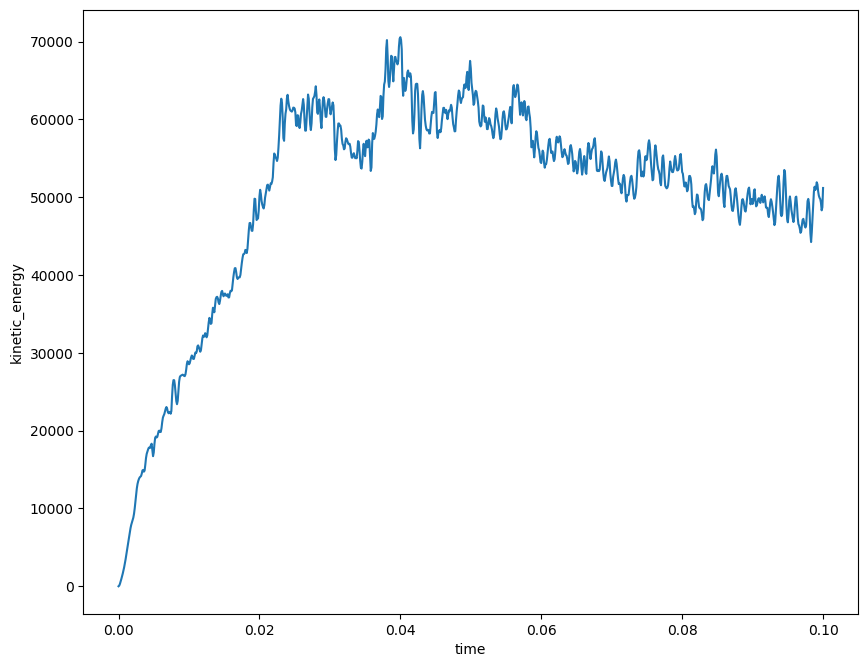

In [24]:
solutions['njit'].kinetic_energy.sum(dim='particle').plot.line()

In [25]:
N_bins = 100
N_times = 1000
for solution in solutions.values():
    density = N / L ** 3

    from scipy import spatial

    import tqdm.auto as tqdm

    all_histograms = []
    max_L = L
    bins, dx = np.linspace(0, max_L, N_bins, endpoint=True, retstep=True)
    our_times = solution.time[np.linspace(0, solution.time.size, N_times, endpoint=False, dtype=int)]
    spatial_bins = (bins[1:] + bins[:-1] )/2
    for time in tqdm.tqdm(our_times):
        pos = solution.position.sel(time=time)
        tree = spatial.cKDTree(pos)

        histograms = []
        for particle in range(N):
            distances, indices = tree.query(pos.sel(particle=particle), range(2, N))
            hist, final_bins = np.histogram(distances, bins)
            rdf = hist / (4 * np.pi * dx * density)
            histograms.append(rdf)
        all_histograms.append(histograms)


    
    da = xarray.DataArray(all_histograms,
                          dims=('time', 'particle', 'spatial_bins'),
                          coords = {'time': our_times, 'spatial_bins': spatial_bins, 'particle': solution.particle})
#     solution.coords['spatial_bins'] = spatial_bins

#     solution['rdf'] = (('time', 'particle', 'spatial_bins'), np.array(all_histograms))

#     solution.rdf.mean(dim='particle').isel(time=-3).plot.line()


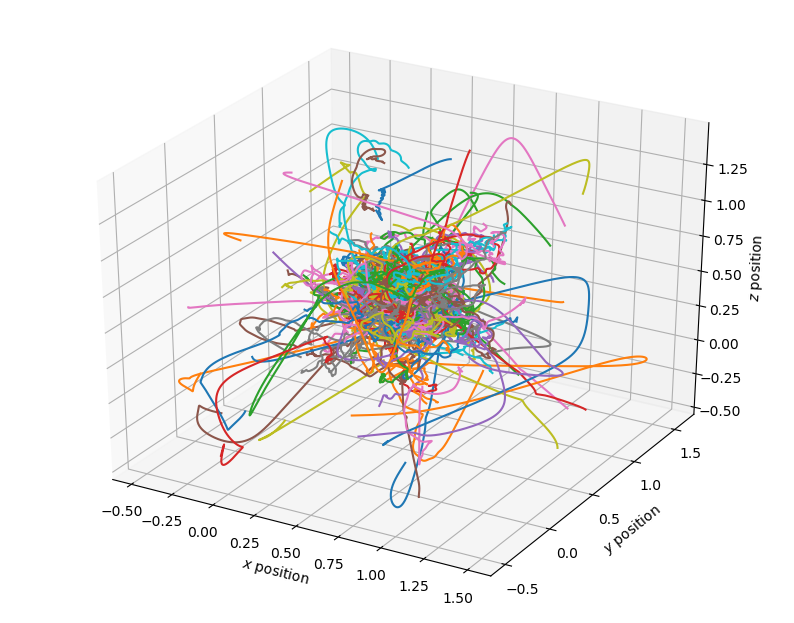

In [26]:
solution.particletracker.plot_trajectories()

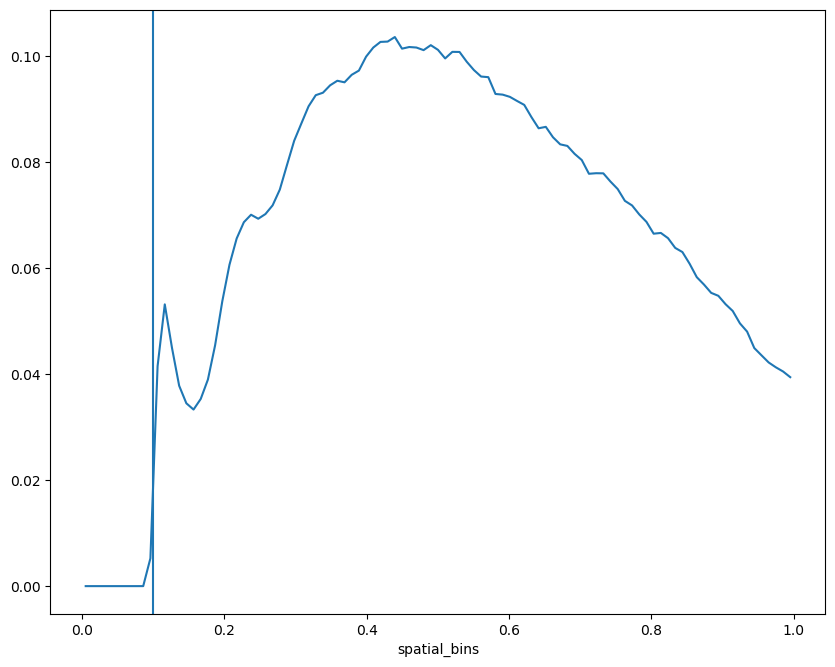

In [27]:
import matplotlib.pyplot as plt

da.isel(time=range(50, 1000)).mean(dim=['particle', 'time']).plot.line()
plt.axvline(eq_distance)

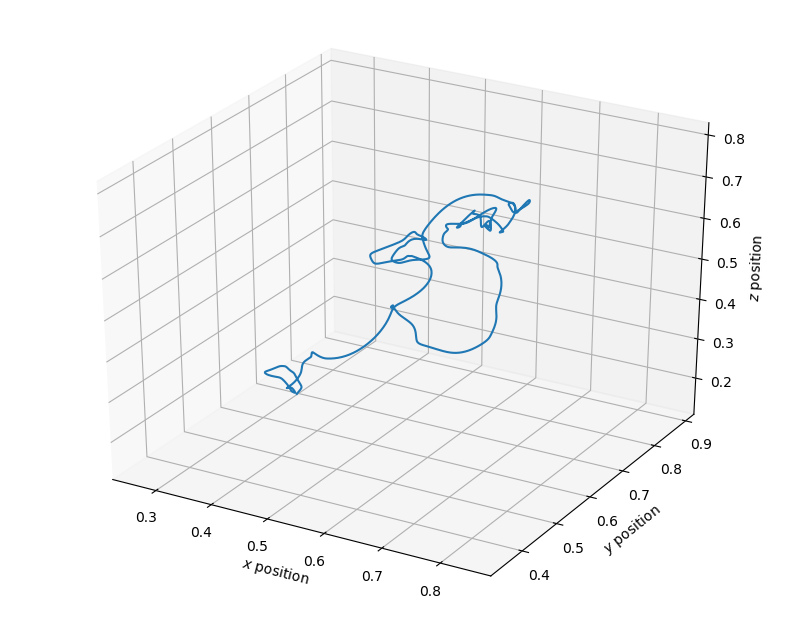

In [28]:
solution.sel(particle=[30]).particletracker.plot_trajectories()

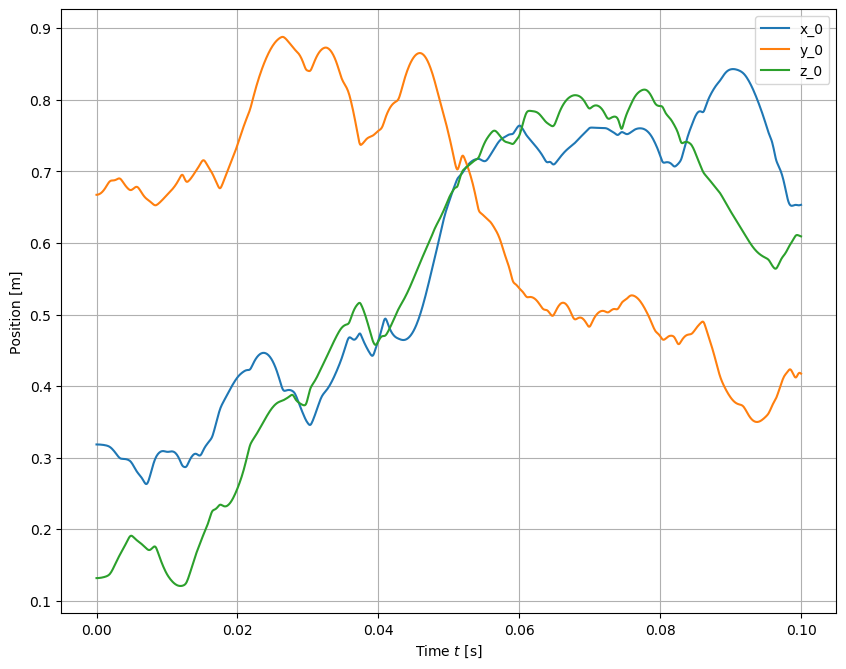

In [29]:
solution.sel(particle = [30]).particletracker.plot_time_trajectories()

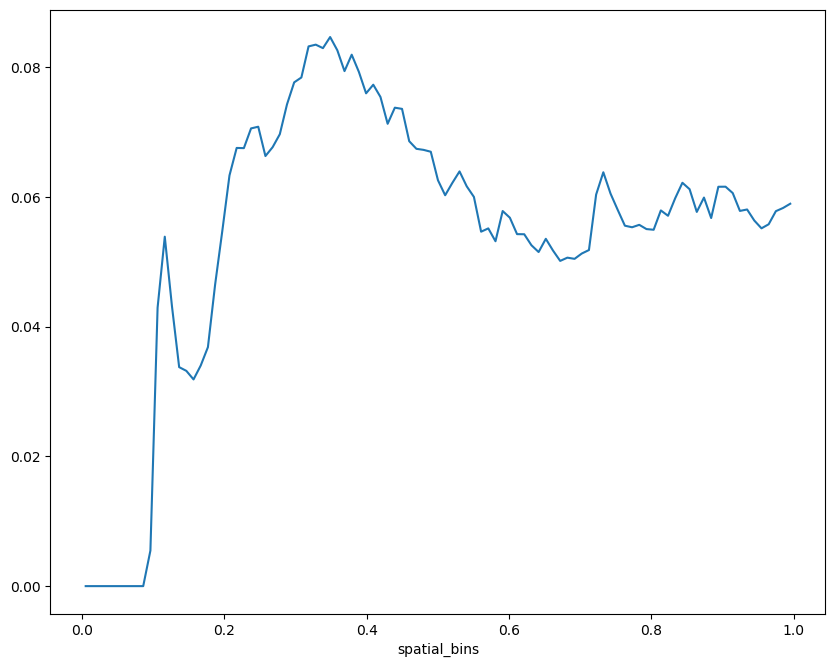

In [30]:
da.isel(time=range(900, 1000)).mean(dim=['particle', 'time']).plot.line()

In [31]:
np.array(all_histograms).shape

(1000, 128, 99)

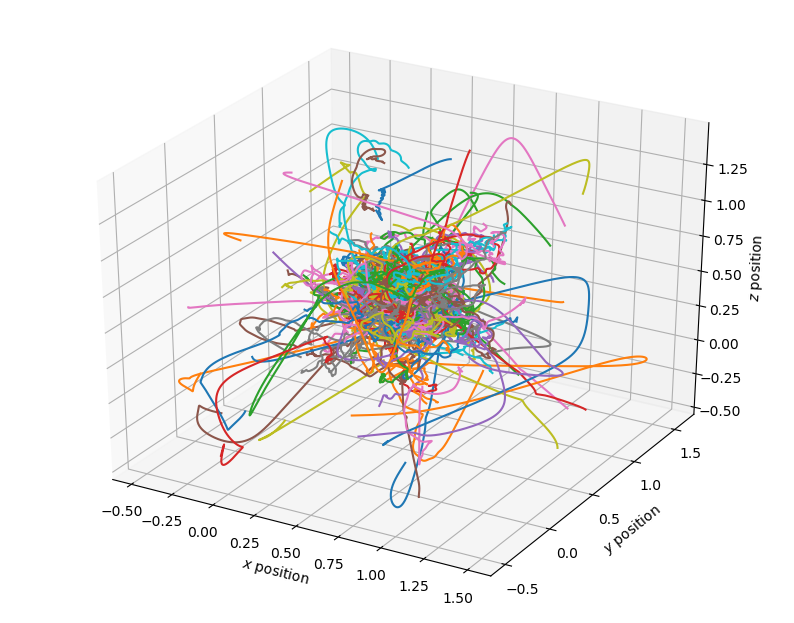

In [32]:
solution.particletracker.plot_trajectories()

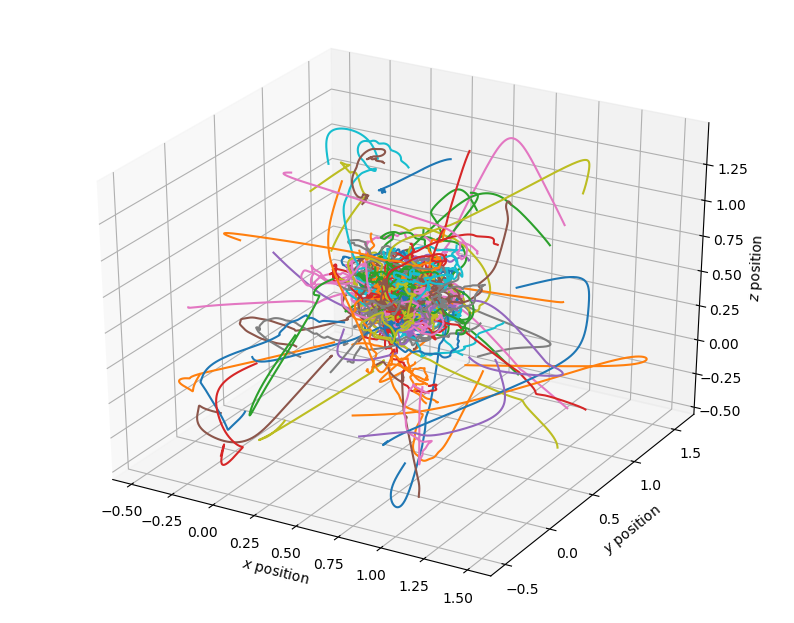

In [33]:
solution.isel(time=range(solution.time.size//10 * 4, solution.time.size // 10 * 10)).particletracker.plot_trajectories()

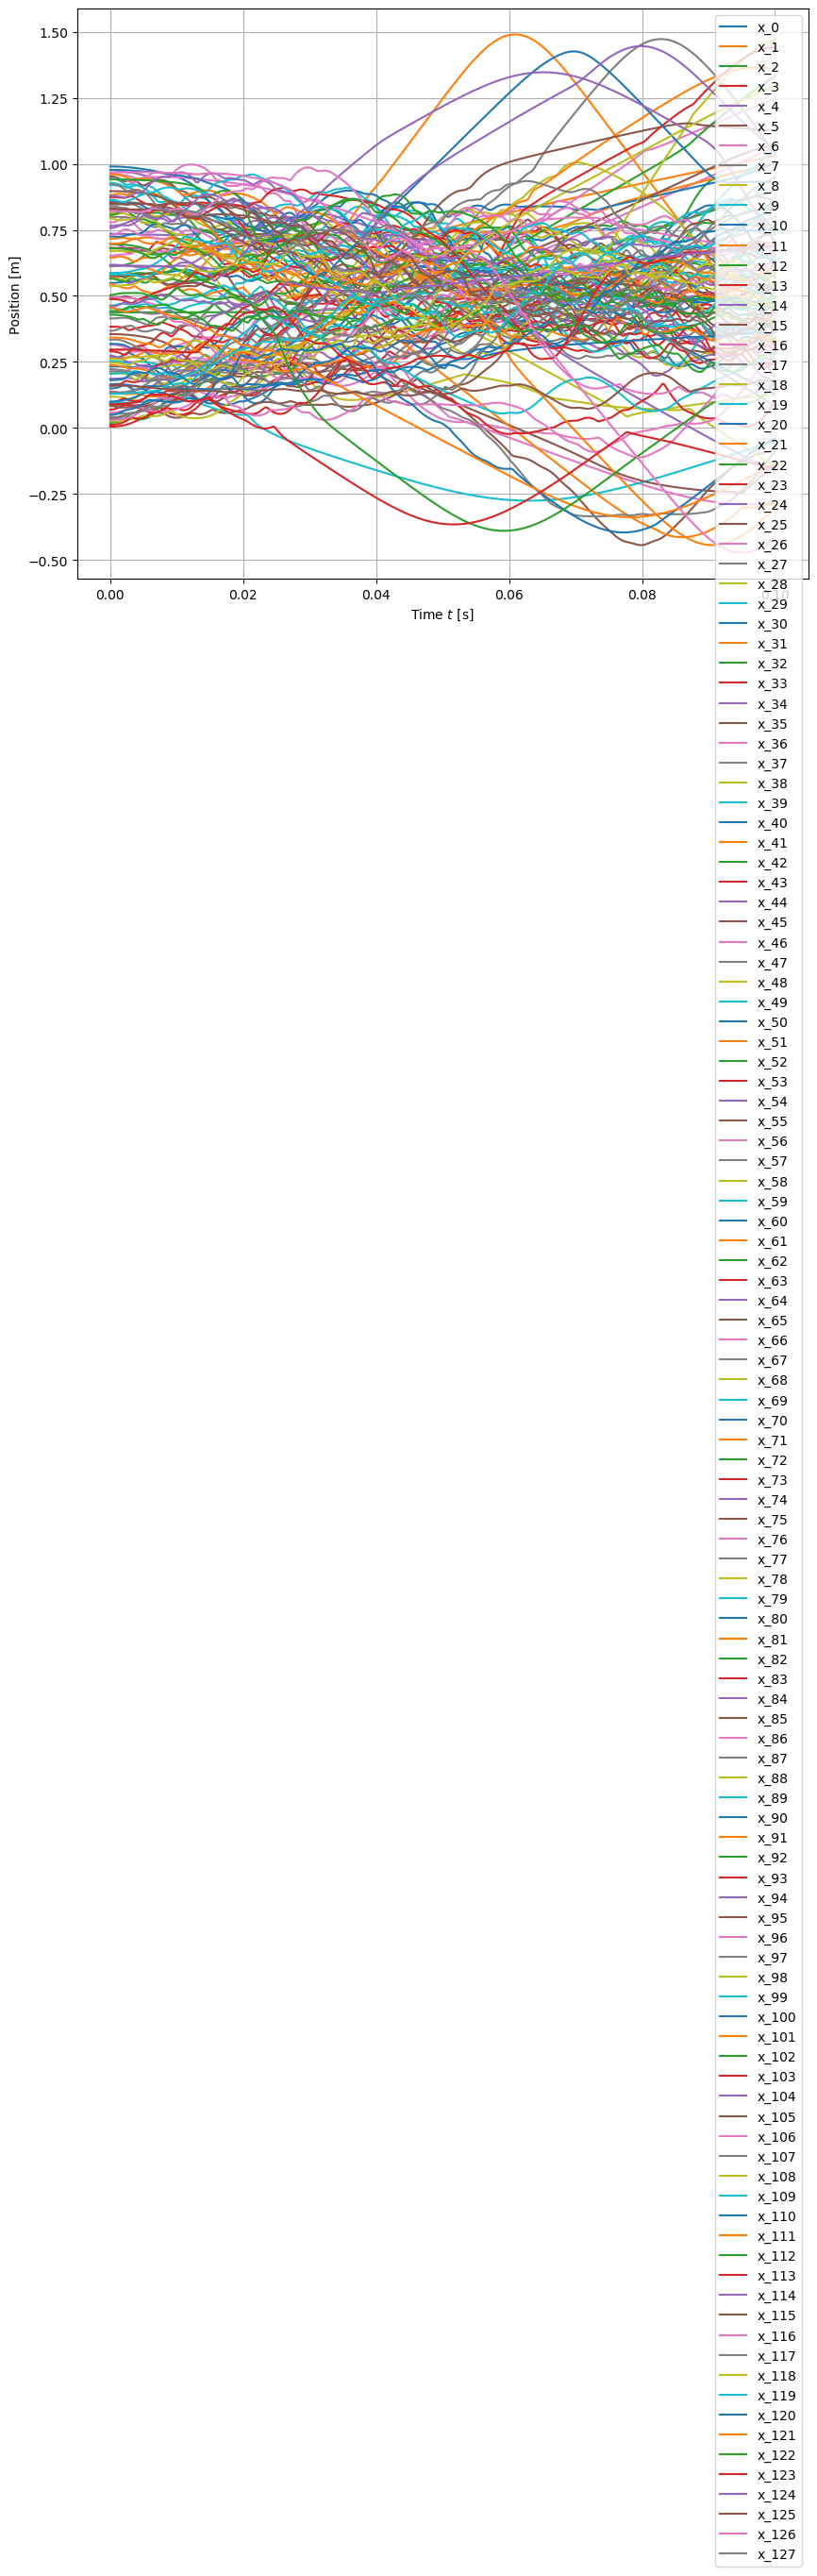

In [34]:
solution.particletracker.plot_time_trajectories('x')

In [35]:
solutions

{'njit': <xarray.Dataset>
 Dimensions:         (dimension: 3, particle: 128, time: 1001)
 Coordinates:
   * time            (time) float64 0.0 0.000101 0.000201 ... 0.0998 0.0999 0.1
   * particle        (particle) int64 0 1 2 3 4 5 6 ... 122 123 124 125 126 127
   * dimension       (dimension) <U1 'x' 'y' 'z'
 Data variables:
     position        (time, particle, dimension) float64 0.5488 0.7152 ... 0.6484
     velocity        (time, particle, dimension) float64 -0.001163 ... -14.44
     B               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
     E               (time, particle, dimension) float64 2.327e+03 ... -1.44e+04
     timestep        (time) float64 1e-06 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
     kinetic_energy  (time, particle) float64 7.749e-06 8.13e-05 ... 261.6 365.2
 Attributes:
     particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)}

In [45]:
solution = solutions['njit']
import pyvista
fig = pyvista.PlotterITK()
for particle in range(N):
    solution.particletracker.visualize(fig, particle=particle, stride=10);
fig.add_mesh(pyvista.Cube(bounds=(0, L.si.value, 0, L.si.value, 0, L.si.value)), opacity=0.1)
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…